In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

# Data preprocessing 
## Data preparation:
* Fix NA values
* Parse date-time into pandas dataframe index
* Specified clear names for each columns

In [413]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [414]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("** DATA PROCESSING COMPLETED **")
dataset.to_csv('pollution.csv')

** DATA PROCESSING COMPLETED **


# Importing and visualizing the data


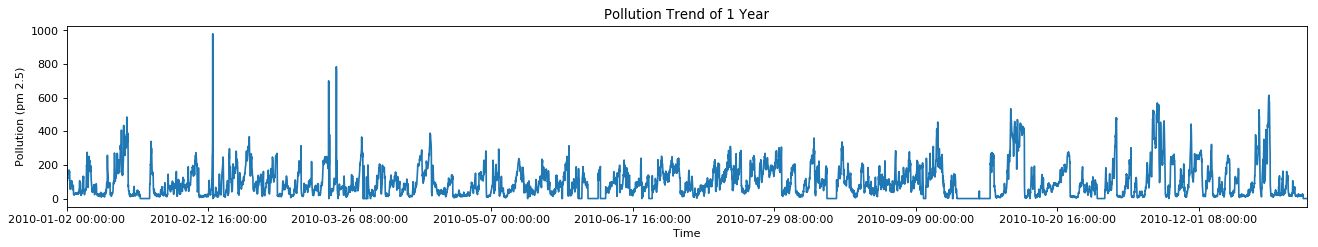

In [554]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [417]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categorical_features=[4])
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [418]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
dataset= ohe.fit_transform(dataset).toarray()
dataset = dataset[:,1:]
#Creating dataset for RNN
pollution_data = dataset[:,3]
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1))
#Creating the dataset for DNN
weather_data = wea_scaler.fit_transform(dataset[:,[0,1,2,4,5,6,7,8,9]])
dataset = pd.read_csv('pollution.csv',index_col='date')

Shape:  (43800, 10)


# Splitting the data into train and test set

In [419]:
#FOR RNN DATA
training_set_rnn = pollution_data[:40000,:]
training_set_dnn = weather_data[:40000,:]
test_set_rnn = pollution_data[40000:,:]
test_set_dnn = weather_data[40000:,:]

In [421]:
def next_batch(training_data_rnn,training_data_dnn,steps):
    """
    INPUT: Data(For RNN and DNN), Time Steps per batch
    OUTPUT: Input batch for RNN and DNN at 't' and Output data (pollution) at 't+1'
    """
    
    # Randomly initializing the start point
    ts_start = np.random.randint(low = 0, high = len(training_data_rnn)-steps)
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch_rnn = training_data_rnn[ts_start: ts_start + steps + 1]
    y_batch_dnn = training_data_dnn[ts_start: ts_start + steps + 1]
    # Values for RNN reshaped to (-1,steps,1)
    return y_batch_rnn[:-1,:].reshape(-1,steps,1) , y_batch_dnn[:-1,:].reshape(steps,-1),y_batch_rnn[1:,:].reshape(-1,steps,1)
    

In [422]:
import os
#Setting up tensorflow on GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from nn_function import *

In [440]:
#Reseting the default global graph
tf.reset_default_graph()

# Creating the neural network

In [441]:
#Declarying the constants
NUMBER_NEU = 128
N_IP = 1
N_OP = 1
STEPS = 24*3
LR = 0.0001
#For 40k iterations
ITER = 40000
#Output neurons for the LSTM and DNN layers
N_OUT =128

In [442]:
#Placeholders for input batches
x_rnn = tf.placeholder(dtype=tf.float32,shape=(None,None,N_IP))
x_dnn = tf.placeholder(dtype=tf.float32,shape=(None,9))
#Placeholders for output batches
y= tf.placeholder(dtype=tf.float32,shape=(None,None,N_OP))
#For dropout layers
hold_proba = tf.placeholder(dtype=tf.float32)

In [443]:
#Making the LSTM cell
cell = dropout_wrapper(hold_proba,create_LSTM_cell(NUMBER_NEU))

In [444]:
#RNN output
output , states = create_RNN(cell,x_rnn)
#Selecting the final output form the layer
rnn_output = output[-1]
#Connecting the output to a DNN layer
lstm_fc_out = dnn_layer(rnn_output,N_OUT,name="LSTM_op")
lstm_fc_drop = tf.nn.dropout(lstm_fc_out, hold_proba,name="drop0")

In [445]:
#Making the dnn layers with the DNN data
dnn_op = dnn_layer(x_dnn,N_FC_OUT)

In [446]:
#Connecting/Concatenating the DNN and RNN layers
connected_layer = tf.concat([dnn_op, lstm_fc_drop], axis=1,name="connected")
dropout_layer = tf.nn.dropout(connected_layer,hold_proba,name="drop1")
#Adding another DNN+dropout layer with relu activation
connected_layer2 = tf.nn.relu(dnn_layer(dropout_layer,size=1024),name="dnn1")
dropout_layer2 = tf.nn.dropout(connected_layer2,hold_proba,name="drop2")

In [447]:
#Calculating the final output node with Sigmoid activation
network_op = tf.sigmoid(dnn_layer(dropout_layer2,1),name="network_op")

In [448]:
#Creating the MAE loss function
loss = tf.reduce_mean(tf.abs(network_op-y))
#Creating the optimizer and trainer
optim = tf.train.AdamOptimizer(learning_rate=LR)
train = optim.minimize(loss)

In [449]:
#Creating the varaible initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [454]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(ITER):
        x_rnn_batch,x_dnn_batch,y_batch = next_batch(training_set_rnn,training_set_dnn,steps=STEPS)
        sess.run(train,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch , hold_proba:0.8})
        if i % 100 == 0:
            x_rnn_test,x_dnn_test,y_test = next_batch(test_set_rnn,test_set_dnn,steps=1000)
            print("At step",i,"\t\tMean Absolute Error (Train): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch , hold_proba:1.0})),"\t\tMean Absolute Error (Test): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_test,x_dnn:x_dnn_test ,y: y_test , hold_proba:1.0})))
    saver.save(sess, "Pollution_model/model")

At step 0 		Mean Absolute Error (Train): 0.76322 		Mean Absolute Error (Test): 0.74816
At step 100 		Mean Absolute Error (Train): 0.02558 		Mean Absolute Error (Test): 0.09713
At step 200 		Mean Absolute Error (Train): 0.04010 		Mean Absolute Error (Test): 0.03719
At step 300 		Mean Absolute Error (Train): 0.03993 		Mean Absolute Error (Test): 0.03018
At step 400 		Mean Absolute Error (Train): 0.05782 		Mean Absolute Error (Test): 0.03485
At step 500 		Mean Absolute Error (Train): 0.03192 		Mean Absolute Error (Test): 0.03537
At step 600 		Mean Absolute Error (Train): 0.01928 		Mean Absolute Error (Test): 0.03481
At step 700 		Mean Absolute Error (Train): 0.02608 		Mean Absolute Error (Test): 0.03118
At step 800 		Mean Absolute Error (Train): 0.04196 		Mean Absolute Error (Test): 0.03354
At step 900 		Mean Absolute Error (Train): 0.02490 		Mean Absolute Error (Test): 0.02352
At step 1000 		Mean Absolute Error (Train): 0.01996 		Mean Absolute Error (Test): 0.02674
At step 1100 		Mean Ab

At step 9200 		Mean Absolute Error (Train): 0.00818 		Mean Absolute Error (Test): 0.01382
At step 9300 		Mean Absolute Error (Train): 0.01727 		Mean Absolute Error (Test): 0.01383
At step 9400 		Mean Absolute Error (Train): 0.02998 		Mean Absolute Error (Test): 0.01563
At step 9500 		Mean Absolute Error (Train): 0.01230 		Mean Absolute Error (Test): 0.01358
At step 9600 		Mean Absolute Error (Train): 0.01020 		Mean Absolute Error (Test): 0.01389
At step 9700 		Mean Absolute Error (Train): 0.01431 		Mean Absolute Error (Test): 0.01381
At step 9800 		Mean Absolute Error (Train): 0.00605 		Mean Absolute Error (Test): 0.01212
At step 9900 		Mean Absolute Error (Train): 0.02176 		Mean Absolute Error (Test): 0.01427
At step 10000 		Mean Absolute Error (Train): 0.01703 		Mean Absolute Error (Test): 0.01437
At step 10100 		Mean Absolute Error (Train): 0.01325 		Mean Absolute Error (Test): 0.01198
At step 10200 		Mean Absolute Error (Train): 0.01354 		Mean Absolute Error (Test): 0.01233
At step

At step 18300 		Mean Absolute Error (Train): 0.02063 		Mean Absolute Error (Test): 0.01270
At step 18400 		Mean Absolute Error (Train): 0.02314 		Mean Absolute Error (Test): 0.01059
At step 18500 		Mean Absolute Error (Train): 0.01989 		Mean Absolute Error (Test): 0.01167
At step 18600 		Mean Absolute Error (Train): 0.00898 		Mean Absolute Error (Test): 0.01479
At step 18700 		Mean Absolute Error (Train): 0.00448 		Mean Absolute Error (Test): 0.01059
At step 18800 		Mean Absolute Error (Train): 0.02357 		Mean Absolute Error (Test): 0.01035
At step 18900 		Mean Absolute Error (Train): 0.03125 		Mean Absolute Error (Test): 0.01199
At step 19000 		Mean Absolute Error (Train): 0.02685 		Mean Absolute Error (Test): 0.01441
At step 19100 		Mean Absolute Error (Train): 0.02196 		Mean Absolute Error (Test): 0.01461
At step 19200 		Mean Absolute Error (Train): 0.01543 		Mean Absolute Error (Test): 0.01182
At step 19300 		Mean Absolute Error (Train): 0.01685 		Mean Absolute Error (Test): 0.01275

At step 27400 		Mean Absolute Error (Train): 0.02292 		Mean Absolute Error (Test): 0.01207
At step 27500 		Mean Absolute Error (Train): 0.01456 		Mean Absolute Error (Test): 0.01156
At step 27600 		Mean Absolute Error (Train): 0.01420 		Mean Absolute Error (Test): 0.01433
At step 27700 		Mean Absolute Error (Train): 0.02094 		Mean Absolute Error (Test): 0.00990
At step 27800 		Mean Absolute Error (Train): 0.03510 		Mean Absolute Error (Test): 0.01358
At step 27900 		Mean Absolute Error (Train): 0.02785 		Mean Absolute Error (Test): 0.01107
At step 28000 		Mean Absolute Error (Train): 0.00988 		Mean Absolute Error (Test): 0.00958
At step 28100 		Mean Absolute Error (Train): 0.00587 		Mean Absolute Error (Test): 0.01461
At step 28200 		Mean Absolute Error (Train): 0.02307 		Mean Absolute Error (Test): 0.01274
At step 28300 		Mean Absolute Error (Train): 0.00873 		Mean Absolute Error (Test): 0.01478
At step 28400 		Mean Absolute Error (Train): 0.00810 		Mean Absolute Error (Test): 0.01033

At step 36500 		Mean Absolute Error (Train): 0.00672 		Mean Absolute Error (Test): 0.00958
At step 36600 		Mean Absolute Error (Train): 0.01974 		Mean Absolute Error (Test): 0.01155
At step 36700 		Mean Absolute Error (Train): 0.00857 		Mean Absolute Error (Test): 0.01462
At step 36800 		Mean Absolute Error (Train): 0.00755 		Mean Absolute Error (Test): 0.00932
At step 36900 		Mean Absolute Error (Train): 0.01352 		Mean Absolute Error (Test): 0.00919
At step 37000 		Mean Absolute Error (Train): 0.01176 		Mean Absolute Error (Test): 0.01493
At step 37100 		Mean Absolute Error (Train): 0.02118 		Mean Absolute Error (Test): 0.01349
At step 37200 		Mean Absolute Error (Train): 0.01352 		Mean Absolute Error (Test): 0.01444
At step 37300 		Mean Absolute Error (Train): 0.00622 		Mean Absolute Error (Test): 0.01120
At step 37400 		Mean Absolute Error (Train): 0.00904 		Mean Absolute Error (Test): 0.01249
At step 37500 		Mean Absolute Error (Train): 0.01836 		Mean Absolute Error (Test): 0.01163

# Visualizing and testing the model 

In [494]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [528]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, "Pollution_model/model")
    #Preparing batches
    x_rnn_batch,x_dnn_batch,y_batch = next_batch(test_set_rnn,test_set_dnn,steps=3001)
    #Predicting the output
    output = sess.run(network_op, feed_dict={x_rnn:x_rnn_batch,x_dnn:x_dnn_batch, hold_proba:1.0})

INFO:tensorflow:Restoring parameters from Pollution_model/model


In [532]:
#Inverse scaling the predicted and actual values
y_inversed = pol_scaler.inverse_transform(y_batch.reshape(1,3001)[:,:-1]).reshape(-1,1)
pred_inversed = pol_scaler.inverse_transform(output.reshape(1,3001)[:,1:]).reshape(-1,1)
dataframe = np.append(y_inversed,pred_inversed,1)

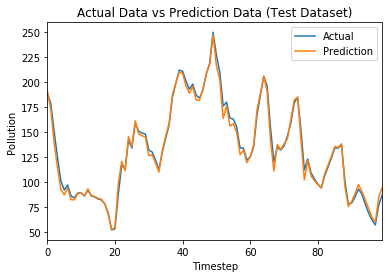

Mean Absolute Error (Test)	=	 4.13500152213
Root Mean Squared Error (Test)	=	 6.30745483054


In [535]:
##Creating the dataframe
df = pd.DataFrame(dataframe,columns=['Actual','Prediction'])
#Plotting the graph
df[:100].plot()
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
#Calculating MAE and RMSE error
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
score_mse = mean_squared_error(y_true,y_pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)

In [536]:
#Converting dataset to spreadsheet
df.to_csv('prediction.csv')

# Predicting Future data

In [646]:
with tf.Session() as sess:
    
    # Restoring the model
    saver.restore(sess, "Pollution_model/model")

    #Creating the Seed of 1 Week's data
    train_seed_rnn = list(training_set_rnn[-24*30:])
    train_seed_dnn = list(training_set_dnn[-24*30:])
    test_ind = 0
    #Predicting the next week's data
    for iteration in range(24*7):
        rnn_batch = np.array(train_seed_rnn[-24*30:]).reshape(1, -24*30, 1)
        dnn_batch = np.array(train_seed_dnn[-24*30:])
        y_pred = sess.run(network_op, feed_dict={x_rnn:rnn_batch,x_dnn:dnn_batch, hold_proba:1.0})
        #print("\nPrediction: ",y_pred[0, -1])
        train_seed_rnn.append(y_pred[0, -1])
        #print("Feed_data: ",test_set_dnn[test_ind])
        train_seed_dnn.append(test_set_dnn[test_ind])
        test_ind+=1
        

INFO:tensorflow:Restoring parameters from Pollution_model/model


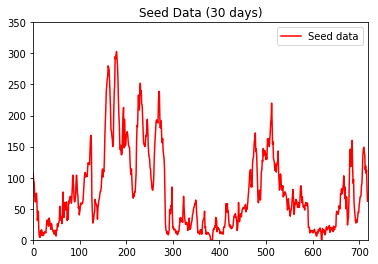

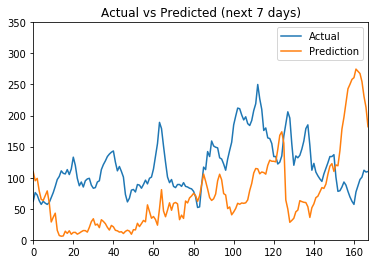

75.2162506183


In [647]:
#Inverse scaling the values
seed_data = pol_scaler.inverse_transform(training_set_rnn[-24*30:])
prediction_data = pol_scaler.inverse_transform(np.array(train_seed_rnn[-24*7:]).reshape(1, -1))
actual_data =  pol_scaler.inverse_transform(test_set_rnn[:24*7])
pd.DataFrame(list(seed_data),columns=['Seed data']).plot(c='Red')
plt.ylim((0,350))
plt.title("Seed Data (30 days)")
plt.show()
df = pd.DataFrame({'Prediction' :prediction_data.reshape(1,-1)[0], 'Actual':actual_data.reshape(1,-1)[0]})
df.plot()
plt.ylim((0,350))
plt.title("Actual vs Predicted (next 7 days)")
plt.show()
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
print(score_mae)